In [154]:
#SETUP with Libraries and Constants

import pandas as pd
import numpy as np
import matplotlib.axes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = np.array([994.2, 947.4,-267.4,-261.5,])

# Z coordinates translations
local_z_shifts = np.array([z*ZCELL for z  in range(0,4)])
global_z_shifts = np.array([823.5, 0, 823.5, 0])

#Define Zooms for the plotting function
zooms = {0:((280, 1000), (775, 925)), 
         1:((235, 960), (-50, 100)),
         2:((-1000, -250), (775, 925)),
         3:((-1000, -250), (-50, 100)),
         4:((-1000, 1000), (-100, 1000))}

In [155]:
with open("data/Run000260/data_000000.txt", 'r+') as file:
    body = file.readlines()

column_names = ["chamber", "layer", "x_left", "x_right", "time"]
data = []

for line in body[:1000]:
    info = line.replace("\n", "").split(" ")
    hits = [info[5*i+2:5*i+7] for i in range(int(info[1]))]
    event = pd.DataFrame(hits, columns = column_names, dtype=float).astype({"chamber":"int", "layer":"int"}).drop(labels="time", axis=1)
    data.append(event)


In [156]:
def coords_conv(event: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns global points in the xz plane from local coordinates, where the points returned
    are in the format (x,z), always given as left_point, right_point.

    It uses global/local transformation given in the Project guide.

    ---

    Input:

    `event`: pandas.DataFrame, format: chamber | layer | x_left | x_right
        The event (line in data.txt) given as a DataFrame. The rows represent the single hits, with format given above. 
        Note that this can be used for single hits (i.e. a single row in the DataFrame).

    ---    
    
    Output:

    `left_points`: numpy.ndarray, shape:(2, N)
        An ndarray containing the left points in the format [x, z]. 
        Note the shape (2, N) in order to get all the x's and z's as vectors

    `right_points`: numpy.ndarray, shape:(2, N)
        An ndarray containing the right points in the format [x, z]. 
        Note the shape (2, N) in order to get all the x's and z's as vectors

    """

    chamber = event["chamber"]
    layer = event["layer"]-1
    x_left, x_right = event["x_left"], event["x_right"]

    x_left_prime = global_x_shifts[chamber] - x_left
    x_right_prime = global_x_shifts[chamber] - x_right

    z = global_z_shifts[chamber] + local_z_shifts[layer]

    left_points, right_points = np.stack([x_left_prime, z]), np.stack([x_right_prime, z])

    return left_points, right_points




def cells_conv(event: pd.DataFrame) -> np.ndarray:
    """
    Returns the cells centers given the event with several hits, one center per hit. The centers are already in global coordinates, 
    account for the alternating pattern between layers in the detector.

    ---

    Input:

    `event`: pandas.DataFrame, format: chamber | layer | x_left | x_right
        The event (line in data.txt) given as a DataFrame. The rows represent the single hits, with format given above. 
        Note that this can be used for single hits (i.e. a single row in the DataFrame).

    ---

    Output:

    `center_points`: numpy.ndarray, shape:(N, 2)
        An ndarray containing the center of the cells in the format [x, z]. 
        Note the shape (N, 2) in order to iterate through the different N centers.
    
    """

    # Adding XCELL/2 at the end is due to the centers being at the center of the cells (redundant word joke), meaning that we take the floor
    # function of the coordinate -> Near zero -> The center is at XCELL/2.
    # We subtract the mod2/2 INSIDE the floor to get the correct corrisponding layer, we THEN shift the centers by an additional mod2/2 to
    # actually get the correct center. For example:

    # A point is at 0.8*XCELL in layer 2 -> Belongs to the 0th cell but shifted by half to the right (local coords)
    # A point is at 0.8*XCELL in layer 1 -> Belongs to the 0th cell
    # A point is at 0.3*XCELL in layer 2 -> Belongs to the -1th cell shifted by half to the right (local coords)
    # Notice the last example is actually illegal in physical reality, and shouldn't exist in the data (no half-cells can be made).

    #Modular arithmetic is borderline magic

    centers = np.floor((event["x_left"]/XCELL) - (np.mod(event["layer"]-1, 2)/2))*XCELL + XCELL*(1/2 + np.mod(event["layer"]-1, 2)/2)

    chamber = event["chamber"]
    layer = event["layer"] - 1

    x_centers = global_x_shifts[chamber] - centers
    z = global_z_shifts[chamber] + local_z_shifts[layer]

    center_points = np.stack([x_centers, z]).T

    return center_points


In [157]:
def event_plot(event: pd.DataFrame, ax: matplotlib.axes.Axes, zoom: int = 4, xlim_manual : tuple[float, float] = None) -> pd.DataFrame:
    """
    Plots the table of hits (event) on the given ax, marking the hit points and the corresponding triggered cells.
    If zoom is specified, the graph is zoomed on the corresponding detector [0->3], otherwise defaults to the larger picture.
    If an xlim is specified, it can be horizontally zoomed, otherwise the plot gets the xlim from the default constants for each detector.

    ---

    Input:

    `event`: pandas.DataFrame, format: chamber | layer | x_left | x_right
        The event (line in data.txt) given as a DataFrame. The rows represent the single hits, with format given above.
        Note that this can be used for single hits (i.e. a single row in the DataFrame).

    `ax`: matplotlib.axes.Axes
        The ax on which to plot the objects.

    `zoom`: int, optional
        The detector on which to zoom on [0, 1, 2, 3]. If value is not legal, it defaults to 4.

    `xlim`: tuple(int, int), optional
        Custom zoom on the x axis. Default is None.
     
    ---

    Output:

    `event_modified`: pandas.DataFrame
        Input event but with x_left, z_left and x_right, z_right added in global coordinates. Accessible with the same name 
        in the column, as in format: chamber | layer | x_left | x_right | z_left | z_right

    """
    
    #Use custom values for detectors zoom / xlim zoom, in case provided.
    if zoom not in [0,1,2,3]: zoom=4
    xlim, ylim = zooms[zoom]
    if xlim_manual is not None: xlim = xlim_manual


    #Calculate points of hit in global coordinates
    left_points, right_points = coords_conv(event)


    #Set the limits for the ax to plot the picture
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)


    #Create big gray rectangles (detectors) by taking the bottom-left corner (x-16.5*XCELL, z-ZCELL*0.5), width and height, plot them
    rects = [patches.Rectangle((x-16.5*XCELL, z-ZCELL*0.5), 
                               16.5*XCELL, 4*ZCELL, 
                               linewidth=1, edgecolor='darkgray', facecolor='none') for x,z in zip(global_x_shifts, global_z_shifts)]
    
    for rect in rects: ax.add_patch(rect)


    #Create small gray rectangles (cells)
    #For each point, find the nearest center in global coords (format: x_center, z_center, layer) and plot according to alternate pattern
    centers = cells_conv(event)
    small_rects = [patches.Rectangle((center[0]-0.5*XCELL, center[1]-0.5*ZCELL), 
                                     XCELL, ZCELL, 
                                     linewidth=1, edgecolor="darkgray", facecolor="none") for center in centers]
    for rect in small_rects: ax.add_patch(rect)


    #Plot blue-red points
    ax.plot(left_points[0], left_points[1], ".r")
    ax.plot(right_points[0], right_points[1], '.b')
    

    #Set title and labels
    if zoom != 4: ax.set_title(f"Detector {zoom}")
    else: ax.set_title(f"View of all detectors")
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")

    event_modified = event.copy()
    event_modified["x_left"] = left_points[0]
    event_modified["x_right"] = right_points[0]
    event_modified["z_left"] = left_points[1]
    event_modified["z_right"] = right_points[1]

    plt.plot()


    return event_modified

In [158]:
def fits(event_modified: pd.DataFrame, ax: matplotlib.axes.Axes, global_fit_flag: bool = True):

    #Do global fit with all the points, works fine since they are very separated
    left_points_global = np.stack([event_modified["x_left"], event_modified["z_left"]])
    right_points_global = np.stack([event_modified["x_right"], event_modified["z_right"]])
    global_points = np.concatenate([left_points_global, right_points_global])
    global_fit = np.poly1d(np.polyfit(global_points[0], global_points[1], 1))


    #We need the global points to make the local fits as well, just like in pictures given
    std = np.std(global_points[0])
    linspace = np.linspace(np.min(global_points[0]) - 2*std, np.max(global_points[0]) + 2*std, 100)
    

    # Do a simple linear fit inside each of the detector ONLY if more than three layers are hit
    # Doesn't work, the best linear fit doesn't connect the points

    for value in pd.unique(event_modified["chamber"]):

        event_filtered = event_modified[event_modified["chamber"] == value]

        #If there are hits on at least 3 different layers
        uniques = len(pd.unique(event_filtered["layer"]))

        if uniques>2:

            #The points in each detector are taken, then sorted by z. Alternating colours are then taken
            #i.e. for 4 left/right points, we take R-B-R-B and B-R-B-R, making two linear fits. The one with lowest residual
            #is the correct approach.
            
            #NB This works ONLY because:
            #   - The cells inside the detectors are in an alternating pattern.
            #   - A muon passing through B (R) -> B (R) will never reach the OTHER corresponding detector (or it won't have come from there)
            #     due to angle requirements.

            #Take the points in [[x],[z]] format
            left_points_local = np.stack([event_filtered["x_left"], event_filtered["z_left"]])
            right_points_local = np.stack([event_filtered["x_right"], event_filtered["z_right"]])
            

            #Order by ascending z
            left_points_local = left_points_local[:, left_points_local[1,:].argsort()]
            right_points_local = right_points_local[:, right_points_local[1,:].argsort()]


            #Construct linear fits on both RBRB and BRBR, get coeffs and residuals from each of them
            local_points1 = np.concatenate([left_points_local[:, ::2], right_points_local[:, 1::2]], axis=1)
            coeffs1, residual1, _, _, _ = np.polyfit(local_points1[0], local_points1[1], 1, full=True)
            
            local_points2 = np.concatenate([left_points_local[:, 1::2], right_points_local[:, ::2]], axis=1)
            coeffs2, residual2, _, _, _ = np.polyfit(local_points2[0], local_points2[1], 1, full=True)


            #The one with lowest residual is the best
            if residual1<residual2: local_fit = np.poly1d(coeffs1)
            else: local_fit = np.poly1d(coeffs2)

            ax.plot(linspace, local_fit(linspace), "--c")



    if global_fit_flag: ax.plot(linspace, global_fit(linspace), 'black')
    
    pass

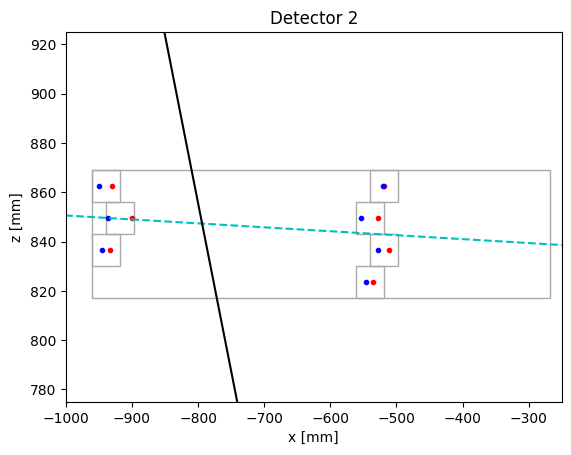

In [171]:
fig, ax = plt.subplots()
detectors_to_fit = (2,3)
data_filtered = []

#Filter data points and get only hits from the couple (2,3) or (0,1)
for point in data:
    single = point[(point["chamber"] == detectors_to_fit[0]) | (point["chamber"] == detectors_to_fit[1])]
    data_filtered.append(single)

#Take single event from filtered ones
event = data_filtered[16]

event_modified = event_plot(event, ax, 2)
fits(event_modified, ax, global_fit_flag=True)

In [166]:
data[14]

,chamber,layer,x_left,x_right
0,2,1,54.67,71.33
1,2,3,53.95,72.05
2,2,2,29.27,54.73
3,2,4,31.16,52.84
4,3,1,19.90,22.10
5,3,3,18.73,23.27
